# Approach 3: Pose lstm baseline

In [1]:
pip install mediapipe

  Using cached numpy-1.26.4-cp310-cp310-macosx_11_0_arm64.whl.metadata (61 kB)
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 MB 16.8 MB/s  0:00:02m0:00:0100:01
Using cached numpy-1.26.4-cp310-cp310-macosx_11_0_arm64.whl (14.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 17.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 MB 15.5 MB/s  0:00:03m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 667.4/667.4 kB 10.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 MB 14.3 MB/s  0:00:03 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.1 MB/s  0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.28.3
    Uninstalling protobuf-5.28.3:
      Successfully uninstalled protobuf-5.28.3
  Attempting uninstall: numpy
    Foun

# PHASE 1 — Pose Extraction from MediaPipe Keypoints

In [ ]:
import cv2 # import necessary libraries and modules
import os
import numpy as np
import mediapipe as mp
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [ ]:
mp_pose=mp.solutions.pose

def extract_keypoints(video_path,max_frames=16):
    cap=cv2.VideoCapture(video_path)
    total_frames=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # choose evenly spaced frames across the video
    frame_idxs=np.linspace(0,total_frames-1,max_frames,dtype=int)
    keypoints=[]

    # initialize MediaPipe pose detector
    with mp_pose.Pose(static_image_mode=False,min_detection_confidence=0.5) as pose:
        for i in frame_idxs:
            cap.set(cv2.CAP_PROP_POS_FRAMES,i)
            ret,frame=cap.read()
            if not ret:
                continue  # skip unreadable frames         
            frame_rgb=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
            results=pose.process(frame_rgb)
            # if pose is detected, store (x,y) for all 33 joints
            if results.pose_landmarks:
                pts=[[lm.x,lm.y] for lm in results.pose_landmarks.landmark]
                keypoints.append(np.array(pts).flatten())
            else:
                # no pose detected then append zeros for this frame
                keypoints.append(np.zeros(33*2))

    cap.release()
    # pad missing frames with the last valid set of keypoints
    if len(keypoints)<max_frames:
        last_frame=keypoints[-1] if keypoints else np.zeros(33*2)
        while len(keypoints)<max_frames:
            keypoints.append(last_frame)

    # truncate extra frames (rarely happen)
    if len(keypoints)>max_frames:
        keypoints=keypoints[:max_frames]

    # return keypoints shaped as [T, 66]
    return np.array(keypoints)


In [ ]:
# sanity check to extract keypoints from a few sample videos
for i in range(5):
    kp=extract_keypoints(train_dataset.samples[i][0]) # run pose extraction on video i
    print(kp.shape)  # should print (16,66) for 16 frames × 33 joints × 2 coords


I0000 00:00:1762513434.669190  654961 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1762513434.736311  660586 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762513434.749319  660592 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


(16, 66)


I0000 00:00:1762513435.524725  654961 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1762513435.576352  660616 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762513435.589061  660616 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


(16, 66)


I0000 00:00:1762513436.380556  654961 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1762513436.432327  660638 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762513436.446132  660638 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


(16, 66)


I0000 00:00:1762513437.247128  654961 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1762513437.297573  660669 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762513437.310332  660669 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


(16, 66)


I0000 00:00:1762513438.097983  654961 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1762513438.149682  660695 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762513438.162158  660695 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


(16, 66)


In [5]:
kp = extract_keypoints("../data/forehand/FH_1.mp4")
print(kp.shape)   # (16, 66)

I0000 00:00:1762513154.865898  654961 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1762513154.930349  657273 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762513154.944809  657273 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762513154.961869  657275 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


(16, 66)


# PHASE 2 — PoseDataset Construction

In [ ]:
class PoseDataset(Dataset):
    def __init__(self,root_dir,classes,frames=16):
        self.samples=[]
        self.classes=classes
        self.frames=frames
        # scan each class folder and collect all video paths
        for label,cls in enumerate(classes):
            folder=os.path.join(root_dir,cls)
            videos=[v for v in os.listdir(folder) if v.endswith(".mp4")]
            for v in videos:
                # store full video path along with its class label
                self.samples.append((os.path.join(folder,v),label))

    def __len__(self):
        # total number of videos in the dataset
        return len(self.samples)

    def __getitem__(self,idx):
        # load a single video and convert it into pose keypoints
        video_path,label=self.samples[idx]
        keypoints=extract_keypoints(video_path,self.frames)     # shape: [T,66]
        keypoints=torch.tensor(keypoints,dtype=torch.float32)   # convert to tensor for training
        return keypoints,label


# PHASE 3 — LSTM-Based Temporal Modeling

In [ ]:
class PoseLSTM(nn.Module):
    def __init__(self,input_size=66,hidden_size=128,num_layers=2,num_classes=4):
        super(PoseLSTM,self).__init__()

        # LSTM processes the sequence of pose keypoints over time.
        # Each frame contributes a 66-dim vector (33 joints × 2 coords).
        self.lstm=nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        # Final linear layer converts the last hidden state into class logits.
        self.fc=nn.Linear(hidden_size,num_classes)

    def forward(self,x):
        # LSTM returns outputs for each time step along with hidden states.
        out,_=self.lstm(x)  
        out=self.fc(out[:,-1,:])
        return out


In [ ]:
classes=["forehand","backhand","serves","nostroke"]
# Load pose-based datasets for each split.
train_dataset=PoseDataset("../data_split/train",classes)
val_dataset=PoseDataset("../data_split/val",classes)
test_dataset=PoseDataset("../data_split/test",classes)

# Wrap datasets in DataLoaders to create training batches.
train_loader=DataLoader(train_dataset,batch_size=4,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=4,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=4,shuffle=False)

print(f"Train videos: {len(train_dataset)}, Val videos: {len(val_dataset)}, Test videos: {len(test_dataset)}")

# Initialize the LSTM model for pose sequences.
# Model predicts class directly from skeletal motion over time.
model=PoseLSTM(num_classes=len(classes))
criterion=nn.CrossEntropyLoss()

# Adam optimizer to update LSTM weights.
optimizer=optim.Adam(model.parameters(),lr=0.001)


Train videos: 80, Val videos: 10, Test videos: 10


# Phase 4 Model Training

In [ ]:
import matplotlib.pyplot as plt
train_losses=[]
val_losses=[]
val_accuracies=[]
EPOCHS=10

for epoch in range(EPOCHS):
    model.train()   # enable training mode (gradients ON)
    total_loss=0.0
    # iterate over batches of pose sequences
    for keypoints,labels in tqdm(train_loader,desc=f"Epoch {epoch+1}/{EPOCHS}"):
        optimizer.zero_grad()
        outputs=model(keypoints)  # LSTM processes [batch,frames,66] sequences
        loss=criterion(outputs,labels) # compute classification loss
        loss.backward()   # backpropagate through LSTM
        optimizer.step()    # update LSTM weights
        total_loss+=loss.item()

    avg_train_loss=total_loss/len(train_loader)
    train_losses.append(avg_train_loss)
    model.eval() # turn off dropout, disable training behavior
    val_loss=0.0
    correct,total=0,0

    with torch.no_grad():  
        for keypoints,labels in val_loader:
            outputs=model(keypoints)
            loss=criterion(outputs,labels)
            val_loss+=loss.item()
            # compute accuracy
            _,preds=torch.max(outputs,1)
            correct+=(preds==labels).sum().item()
            total+=labels.size(0)

    avg_val_loss=val_loss/len(val_loader)
    val_acc=100*correct/total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss:{avg_train_loss:.3f} | Val Loss:{avg_val_loss:.3f} | Val Acc:{val_acc:.2f}%")


Epoch 1/10:   0%|                                        | 0/20 [00:00<?, ?it/s]I0000 00:00:1762514079.506994  654961 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1762514079.578292  673544 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762514079.590799  673546 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[h264 @ 0x11c68b840] mmco: unref short failure
[h264 @ 0x11c68b840] mmco: unref short failure
[h264 @ 0x11c68b840] mmco: unref short failure
[h264 @ 0x11c68b840] mmco: unref short failure
[h264 @ 0x11c68b840] mmco: unref short failure
[h264 @ 0x11c68b840] mmco: unref short failure
[h264 @ 0x11c68b840] mmco: unref short failure
[h264 @ 0x11c68b840] mmco: unref short failure
I0000 00:00:1762514080.167122  654961 gl_context.cc:369] GL version:

Epoch [1/10] | Train Loss: 1.373 | Val Loss: 1.286 | Val Acc: 40.00%


Epoch 2/10:   0%|                                        | 0/20 [00:00<?, ?it/s]I0000 00:00:1762514158.357861  654961 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1762514158.421990  675980 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762514158.434399  675978 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1762514159.477653  654961 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1762514159.529531  676005 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762514159.542313  676005 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disablin

Epoch [2/10] | Train Loss: 1.345 | Val Loss: 1.279 | Val Acc: 40.00%


Epoch 3/10:   0%|                                        | 0/20 [00:00<?, ?it/s]I0000 00:00:1762514237.173265  654961 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1762514237.225187  678222 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762514237.238477  678223 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1762514237.990925  654961 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1762514238.041589  678241 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762514238.054622  678242 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disablin

Epoch [3/10] | Train Loss: 1.313 | Val Loss: 1.267 | Val Acc: 40.00%


Epoch 4/10:   0%|                                        | 0/20 [00:00<?, ?it/s]I0000 00:00:1762514321.036155  654961 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1762514321.089580  681041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762514321.102779  681041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[h264 @ 0x11c7ebd90] mmco: unref short failure
[h264 @ 0x11c7ebd90] mmco: unref short failure
[h264 @ 0x11c7ebd90] mmco: unref short failure
[h264 @ 0x11c7ebd90] mmco: unref short failure
[h264 @ 0x11c7ebd90] mmco: unref short failure
[h264 @ 0x11c7ebd90] mmco: unref short failure
[h264 @ 0x11c7ebd90] mmco: unref short failure
[h264 @ 0x11c7ebd90] mmco: unref short failure
I0000 00:00:1762514321.769953  654961 gl_context.cc:369] GL version:

Epoch [4/10] | Train Loss: 1.212 | Val Loss: 1.274 | Val Acc: 30.00%


Epoch 5/10:   0%|                                        | 0/20 [00:00<?, ?it/s]I0000 00:00:1762514404.050663  654961 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1762514404.107432  683275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762514404.120343  683277 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1762514404.893185  654961 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1762514404.944517  683291 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762514404.957367  683290 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disablin

Epoch [5/10] | Train Loss: 1.199 | Val Loss: 1.318 | Val Acc: 30.00%


Epoch 6/10:   0%|                                        | 0/20 [00:00<?, ?it/s]I0000 00:00:1762514490.462371  654961 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1762514490.525465  685780 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762514490.540324  685785 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1762514491.763986  654961 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1762514491.819094  685804 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762514491.834488  685808 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disablin

Epoch [6/10] | Train Loss: 1.139 | Val Loss: 1.168 | Val Acc: 50.00%


Epoch 7/10:   0%|                                        | 0/20 [00:00<?, ?it/s]I0000 00:00:1762514576.010300  654961 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1762514576.063603  688052 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762514576.076931  688052 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1762514576.897016  654961 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1762514576.948641  688076 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762514576.961147  688076 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disablin

Epoch [7/10] | Train Loss: 1.132 | Val Loss: 1.152 | Val Acc: 30.00%


Epoch 8/10:   0%|                                        | 0/20 [00:00<?, ?it/s]I0000 00:00:1762514659.922798  654961 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1762514659.982908  690433 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762514659.997734  690435 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1762514660.931011  654961 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1762514660.989712  690457 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762514661.004127  690457 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disablin

Epoch [8/10] | Train Loss: 1.055 | Val Loss: 1.199 | Val Acc: 40.00%


Epoch 9/10:   0%|                                        | 0/20 [00:00<?, ?it/s]I0000 00:00:1762514746.367684  654961 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1762514746.423277  692747 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762514746.437111  692747 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1762514747.268533  654961 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1762514747.321012  692768 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762514747.333904  692774 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disablin

Epoch [9/10] | Train Loss: 1.057 | Val Loss: 1.242 | Val Acc: 30.00%


Epoch 10/10:   0%|                                       | 0/20 [00:00<?, ?it/s]I0000 00:00:1762514832.699677  654961 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1762514832.756242  694972 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762514832.770128  694976 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[h264 @ 0x11c6e3270] mmco: unref short failure
[h264 @ 0x11c6e3270] mmco: unref short failure
[h264 @ 0x11c6e3270] mmco: unref short failure
[h264 @ 0x11c6e3270] mmco: unref short failure
[h264 @ 0x11c6e3270] mmco: unref short failure
[h264 @ 0x11c6e3270] mmco: unref short failure
[h264 @ 0x11c6e3270] mmco: unref short failure
[h264 @ 0x11c6e3270] mmco: unref short failure
I0000 00:00:1762514833.438487  654961 gl_context.cc:369] GL version:

Epoch [10/10] | Train Loss: 0.980 | Val Loss: 1.423 | Val Acc: 30.00%


# Phase 5 Model validation

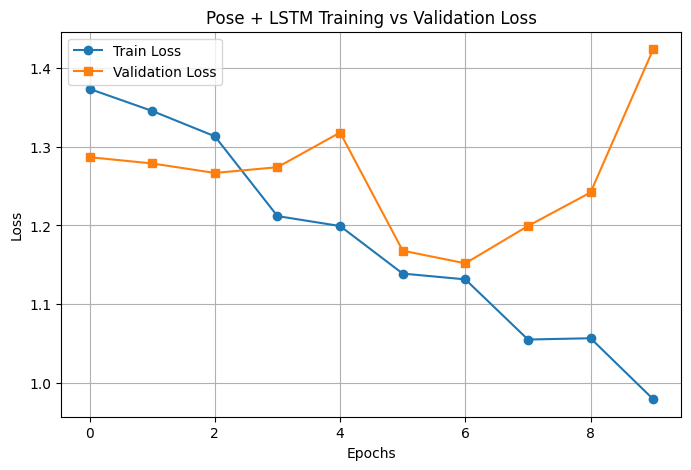

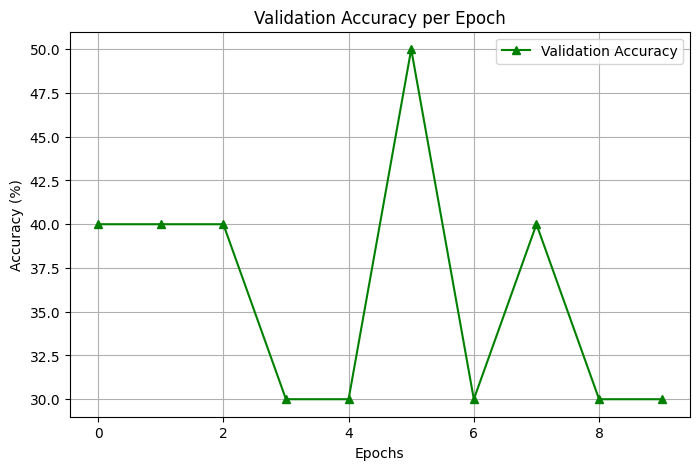

In [ ]:
# training and validation loss curves to show learning behavior over epochs
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.title("Pose + LSTM Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()
# validation accuracy to visualize how well pose-only model generalizes
plt.figure(figsize=(8,5))
plt.plot(val_accuracies, label='Validation Accuracy', color='green', marker='^')
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.eval() #model validation with test accuracy
correct, total = 0, 0
with torch.no_grad():
    for keypoints, labels in test_loader:
        outputs = model(keypoints)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = 100 * correct / total
print(f"Final Test Accuracy: {test_acc:.2f}%") 

I0000 00:00:1762514954.630696  654961 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1762514954.711821  697737 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762514954.725512  697740 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1762514955.513020  654961 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1762514955.564610  697759 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762514955.577211  697761 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1762514956.313726  654961 gl_context

Final Test Accuracy: 50.00%


In [21]:
torch.save(model.state_dict(), "../models/pose_lstm_model.pt")
print("Pose LSTM model saved successfully!")

Pose LSTM model saved successfully!
